
### Spectral Image model v2 - our model (not pretrained) 

### Imports 

In [1]:
import os

#Data Handling
import pandas as pd
import numpy as np

#Spectral image generation
import librosa
from librosa import power_to_db
from librosa import load
from librosa.feature import melspectrogram 
from librosa.display import specshow

#Image Processing 
import cv2

#Machine & Deep Learning
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense
from keras.models import Sequential, Model

#Visualizations
import matplotlib.pyplot as plt
import warnings

#Manual testing packages
import sounddevice as sd
from scipy.io.wavfile import write

warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Load spectral images into arrays

In [27]:
def create_dataset(directory,IMG_WIDTH,IMG_HEIGHT):
    X = []
    Y = [] 
    for i, (subdirs, dirs, files) in enumerate(os.walk(directory)):
        for file in files:
            if not file.startswith('.'):
                label = subdirs.split('/')[-1]
                image = cv2.imread(os.path.join(subdirs,file),0)
                image = cv2.resize(image,(64,64))
                X.append(image)
                Y.append(label)
    return np.array(X),np.array(Y)

In [28]:
savedir = '/Users/sahityasridhar/Documents/OS/dataset/images/'
IMG_WIDTH, IMG_HEIGHT = 64,64
X,Y = create_dataset(savedir,IMG_WIDTH,IMG_HEIGHT)

In [29]:
X.shape

(160, 64, 64)

In [30]:
X = X/255.0

In [31]:
X.shape,Y.shape

((160, 64, 64), (160,))

### One Hot Encode the output

In [32]:
le = LabelEncoder()
Y = le.fit_transform(Y)
NUM_CLASSES = len(le.classes_)
Y = np.eye(NUM_CLASSES)[Y]

### Train test split

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)

In [34]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((112, 64, 64), (48, 64, 64), (112, 6), (48, 6))

In [41]:
X_train = X_train.reshape(X_train.shape[0],IMG_WIDTH,IMG_HEIGHT,1)
X_test = X_test.reshape(X_test.shape[0],IMG_WIDTH,IMG_HEIGHT,1)

###  Image Classification Model

In [49]:
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from keras.models import Sequential, Model

In [156]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(64,64,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [157]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 29, 29, 16)        9232      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)               0         
__________

In [158]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [159]:
history = model.fit(X_train,y_train,batch_size=8,epochs=75,validation_split=0.2)

Train on 89 samples, validate on 23 samples
Epoch 1/75
89/89 [==============================] - 1s 15ms/step - loss: 1.7900 - acc: 0.2360 - val_loss: 1.7783 - val_acc: 0.2609
Epoch 2/75
89/89 [==============================] - 0s 6ms/step - loss: 1.7688 - acc: 0.4045 - val_loss: 1.7469 - val_acc: 0.5652
Epoch 3/75
89/89 [==============================] - 1s 6ms/step - loss: 1.7230 - acc: 0.2472 - val_loss: 1.6039 - val_acc: 0.3913
Epoch 4/75
89/89 [==============================] - 1s 6ms/step - loss: 1.4759 - acc: 0.6067 - val_loss: 1.1537 - val_acc: 0.6522
Epoch 5/75
89/89 [==============================] - 0s 6ms/step - loss: 1.0076 - acc: 0.6629 - val_loss: 0.7297 - val_acc: 0.5652
Epoch 6/75
89/89 [==============================] - 0s 6ms/step - loss: 0.6774 - acc: 0.7303 - val_loss: 0.4669 - val_acc: 0.8261
Epoch 7/75
89/89 [==============================] - 1s 6ms/step - loss: 0.5875 - acc: 0.8315 - val_loss: 0.3591 - val_acc: 0.8261
Epoch 8/75
89/89 [===========================

### Plot Validation and Training Loss curves

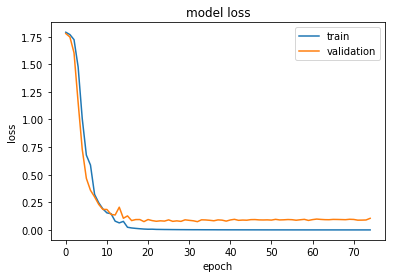

In [160]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Test Data Accuracy 

In [161]:
model.evaluate(X_test,y_test)

48/48 [==============================] - 0s 2ms/step


[0.4538031555712223, 0.9166666666666666]

In [162]:
model.evaluate(X_train,y_train)

112/112 [==============================] - 0s 1ms/step


[0.021647556574732465, 0.9910714285714286]

In [163]:
model.save('V4-best-AudioClassification')

#### Confusion Matrix of predictions

In [172]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
y_true = np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
y_true = le.inverse_transform(y_true)
y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_true,y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, le.classes_, le.classes_)

#### Display Confusion Matrix

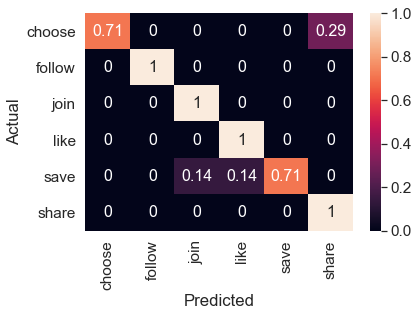

In [173]:
sn.set(font_scale=1.4) 
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) 
ax.set(xlabel = 'Predicted', ylabel='Actual')
plt.show()

#### Analysis of where the model made mistakes

In [266]:
temp = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])
indices = np.isin(X,temp[np.where(y_true!=y_pred),:,:])
indices.shape

(160, 64, 64)

In [279]:
wrong = np.apply_over_axes(np.prod,indices,[1,2])
wrong = wrong.flatten()
wrong_indices = np.where(wrong==1)

In [280]:
np.where(y_true!=y_pred)

(array([21, 24, 29, 47]),)

In [282]:
wrong_indices

(array([ 29,  36,  48,  50, 111, 121]),)

In [285]:
X[29].shape,temp[21].shape

((64, 64), (64, 64))

In [294]:
np.prod(X[29]==temp[21].all())



0

#### Record and create audio file

In [228]:
fs = 44100  # this is the frequency sampling; also: 4999, 64000
seconds = 2  # Duration of recording
 
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
print("Starting: Speak now!")
sd.wait()  # Wait until recording is finished
print("finished")
write('output.mp3', fs, myrecording)  # Save as WAV file

Starting: Speak now!
finished


#### Convert audio file to corresponding spectral images

In [229]:
clip, sample_rate = load('/Users/sahityasridhar/Documents/OS/output.mp3', sr=None)
plt.interactive(False)
fig = plt.figure(figsize=[2.0,2.0])
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
S = melspectrogram(y=clip, sr=sample_rate)
specshow(power_to_db(S, ref=np.max),x_axis='time', y_axis='hz')
plt.savefig('/Users/sahityasridhar/Documents/OS/output.jpg', dpi=1200, bbox_inches='tight',pad_inches=0)
plt.close()    
fig.clf()
plt.close(fig)
plt.close('all')
os.remove('/Users/sahityasridhar/Documents/OS/output.mp3')
del clip,sample_rate,fig,ax,S

#### Image preprocessing 

In [230]:
image = cv2.imread('/Users/sahityasridhar/Documents/OS/output.jpg',0)
sample = cv2.resize(image,(64,64))
sample = sample/255.0
sample = sample.reshape(1,IMG_WIDTH,IMG_HEIGHT,1)
os.remove('/Users/sahityasridhar/Documents/OS/output.jpg')

In [231]:
sample.shape

(1, 64, 64, 1)

#### Retrieve predictions

In [232]:
result = model.predict_classes(sample)

In [233]:
print(result,le.classes_[result])

[3] ['like']
